**GROUP PROJECT 2**
CS 470/670: Alexandra Corso, Sandesh Guthal, Monal Rupapara, Chintan

In [ ]:
# Import libraries and format rcParams and warning filters
from numpy import array
import warnings
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

warnings.filterwarnings("ignore")

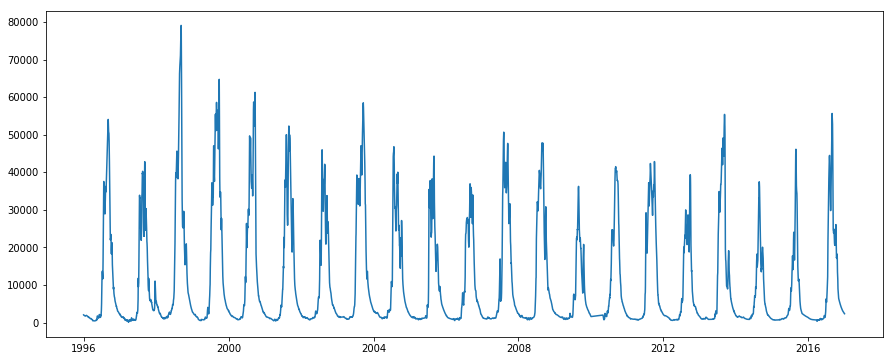

In [ ]:
# Take in dataset and graph for reference
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('http://kdl.cs.umb.edu/CS670/data/Ganges_1996_2016.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data = data.astype('float64')
data.dropna(inplace=True)
plt.plot(data)

In [ ]:
# Split data sets
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix].values, sequence.iloc[end_ix].values
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# run both models with given data
def run_predict(d, p):
  # Split data sets and check shape
  n_steps = 20
  X, y = split_sequence(d, n_steps)
  
  # Split into test, validation, and training
  train_split = 5094 - p
  valid_split = 5824 - p
  X_train, y_train = X[:train_split],y[:train_split]
  X_valid, y_valid = X[train_split:valid_split],y[train_split:valid_split]
  X_test, y_test = X[valid_split:],y[valid_split:]
  
  # Build RNN Model
  rnn = Sequential()
  rnn.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 1)))
  rnn.add(Dense(1))
  rnn.compile(optimizer='adam', loss='mse')
  
  # Fit RNN Model
  rnn.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=200, verbose=1)
  
  # make LSTM model
  lstm = Sequential()
  lstm.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
  lstm.add(Dense(1))
  lstm.compile(optimizer='adam', loss='mse')
  
  # Fit LSTM Model
  lstm.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=200, verbose=1)
  
  # make predictions for RNN
  predict_rnn = rnn.predict(X_test)
 
  # make predictions
  predict_lstm = lstm.predict(X_test)
  
  return predict_rnn, predict_lstm

In [ ]:
def plot_predict(prnn, plstm):
 
  # calculate root mean squared error
  testScore = math.sqrt(mean_squared_error(y_test, prnn))
  
  # calculate root mean squared error
  testScore_lstm = math.sqrt(mean_squared_error(y_test, plstm))
  
  # Show predictions vs ground truth values for RNN
  print('Test Score RNN: %.2f RMSE' % (testScore))
  predict_plot = pd.DataFrame(prnn, data.index[valid_split+n_steps:])
  plt.plot(data)
  plt.plot(predict_plot)
  plt.show()
  
  # Show predictions vs ground truth values for LSTM
  print('Test Score LSTM: %.2f RMSE' % (testScore_lstm))  
  predict_plot_lstm = pd.DataFrame(plstm, data.index[valid_split+n_steps:])
  plt.plot(data)
  plt.plot(predict_plot_lstm)
  plt.show()

In [ ]:
# run models on original data set
rnn_prediction_original, lstm_prediction_original = run_predict(data, 0)

Train on 5094 samples, validate on 730 samples
Epoch 1/200
5094/5094 [==============================] - 1s 245us/step - loss: 10035099.3989 - val_loss: 1530852.2600
Epoch 2/200
5094/5094 [==============================] - 1s 111us/step - loss: 1884269.5769 - val_loss: 943511.3332
Epoch 3/200
5094/5094 [==============================] - 1s 111us/step - loss: 1460659.0266 - val_loss: 699188.9400
Epoch 4/200
5094/5094 [==============================] - 1s 112us/step - loss: 1331403.8275 - val_loss: 578922.8226
Epoch 5/200
5094/5094 [==============================] - 1s 110us/step - loss: 1133073.3541 - val_loss: 521760.4481
Epoch 6/200
5094/5094 [==============================] - 1s 111us/step - loss: 1008734.5040 - val_loss: 443483.6756
Epoch 7/200
5094/5094 [==============================] - 1s 110us/step - loss: 898001.2319 - val_loss: 509802.8130
Epoch 8/200
5094/5094 [==============================] - 1s 109us/step - loss: 811755.2076 - val_loss: 382101.9154
Epoch 9/200
5094/5094 [==

In [ ]:
# plot and score models on original data set
plot_predict(rnn_prediction_original, lstm_prediction_original)

NameError: ignored

That is our result for each model with the original, unstationary, data.

Now we will attept to make the data more stationary and use both models again.

In [ ]:
# invert differenced value
def inverse_diff(pred, history, periods):
  for i in range(len(pred)):
    pred[i] = pred[i] + history[-periods] 
    history.append(pred[i])
  return pred

In [ ]:
# use differencing
periods = 5
ts_dif = data - data.shift(periods=periods)
ts_dif.dropna(inplace=True)

In [ ]:
# run models on differenced data
rnn_prediction_dif, lstm_prediction_dif = run_predict(ts_dif, periods)

In [ ]:
# inverse differnce predictions and plot
history = [x for x in ts_dif.values]
predict = inverse_diff(rnn_prediction_dif, history, periods)
predict_lstm = inverse_diff(lstm_prediction_dif, history, periods)
plot_predict(predict, predict_lstm)